# Fu-Predictor
### Predictions

---

by Fujyn

---

## Goal

- Predict player Stats for a game against another team
- Predict team Winner against another (PCT)
- Predict team and Player LeaderBoard:
    - Best Team in every stats
    - Best Players in every stats

---
## Specifications

- Standard scaler
- Logistic Regression
- Generator

---
## Import packages

In [1]:
# Import default library
import numpy as np
import pandas as pd

# Import usefull library
from sklearn import svm # for Discriminator
from sklearn.model_selection import train_test_split # for train-test split 
from sklearn.preprocessing import StandardScaler # for feature scaling
from sklearn.model_selection import GridSearchCV # for fine-tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics # for evaluation

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression # For data analizis
from sklearn.impute import SimpleImputer # To replace null value in dataframe

import matplotlib.pyplot as plt  # for visualization 
import seaborn as sns  # for coloring 

# for Generator
from scipy import stats # for sampling
from fitter import Fitter # for fitting the best distribution
import copy # for copying nested dictionaries

from sklearn.pipeline import make_pipeline # for prediction

---
## Data initialization

In [15]:
# Read game formated csv file
df = pd.read_csv('../data/games_formated.csv')

df = df.sort_values(by='GAME_DATE_EST').reset_index(drop=True)

# Sort dataframe by GAME_DATE_EST
df = df.loc[df["GAME_DATE_EST"] >= "2009-10-28"].reset_index(drop=True)

df.head(10)

,GAME_ID,G_home,W_PCT_home,G_prev_home,W_PCT_prev_home,G_away,W_PCT_away,G_prev_away,W_PCT_prev_away,WIN_PRCT_home_2g,...,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,GAME_DATE_EST,SEASON,HOME_TEAM_WINS
0,20900008,82.0,0.756,82.0,0.805,82.0,0.427,82.0,0.390,1.0,...,44.0,59.0,0.311,0.520,0.000,10.0,46.0,2009-10-28,2009,1
1,20900007,82.0,0.402,82.0,0.500,82.0,0.805,82.0,0.549,0.0,...,48.0,91.0,0.349,0.649,0.409,19.0,49.0,2009-10-28,2009,1
2,20900005,82.0,0.573,82.0,0.451,82.0,0.439,82.0,0.439,0.5,...,35.0,109.0,0.534,0.840,0.556,23.0,40.0,2009-10-28,2009,1
3,20900016,82.0,0.232,82.0,0.280,82.0,0.561,82.0,0.671,0.5,...,35.0,109.0,0.513,0.741,0.467,19.0,36.0,2009-10-28,2009,0
4,20900015,82.0,0.354,82.0,0.585,82.0,0.646,82.0,0.671,0.5,...,41.0,108.0,0.465,0.800,0.462,30.0,41.0,2009-10-28,2009,0
5,20900014,82.0,0.659,82.0,0.610,82.0,0.585,82.0,0.659,0.5,...,42.0,105.0,0.457,0.862,0.600,26.0,39.0,2009-10-28,2009,1
6,20900006,82.0,0.720,82.0,0.634,82.0,0.500,82.0,0.488,1.0,...,37.0,106.0,0.500,0.700,0.389,19.0,34.0,2009-10-28,2009,1
7,20900012,82.0,0.280,82.0,0.244,82.0,0.207,82.0,0.463,0.0,...,41.0,89.0,0.405,0.786,0.188,13.0,37.0,2009-10-28,2009,1
8,20900011,82.0,0.293,82.0,0.268,82.0,0.415,82.0,0.415,1.0,...,50.0,93.0,0.420,0.862,0.000,20.0,52.0,2009-10-28,2009,1
9,20900010,82.0,0.293,82.0,0.268,82.0,0.476,82.0,0.720,0.5,...,49.0,96.0,0.514,0.552,0.375,20.0,39.0,2009-10-28,2009,0


### Check null values

In [16]:
df.isnull().values.any()

False

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17602 entries, 0 to 17601
Columns: 110 entries, GAME_ID to HOME_TEAM_WINS
dtypes: float64(104), int64(5), object(1)
memory usage: 14.8+ MB


---
## Features Selection

In [18]:
# This feature will be used for the prediction of a classifier which takes those fetures as inputs
features = [
    'G_home', 'G_away',
    'W_PCT_home', 'W_PCT_prev_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home',
    'W_PCT_away', 'W_PCT_prev_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away',
    'WIN_PRCT_home_2g', 'FG_PCT_home_2g', 'FT_PCT_home_2g', 'FG3_PCT_home_2g', 'AST_home_2g', 'REB_home_2g',
    'WIN_PRCT_away_2g', 'FG_PCT_away_2g', 'FT_PCT_away_2g', 'FG3_PCT_away_2g', 'AST_away_2g', 'REB_away_2g',
    'WIN_PRCT_home_4g', 'FG_PCT_home_4g', 'FT_PCT_home_4g', 'FG3_PCT_home_4g', 'AST_home_4g', 'REB_home_4g',
    'WIN_PRCT_away_4g', 'FG_PCT_away_4g', 'FT_PCT_away_4g', 'FG3_PCT_away_4g', 'AST_away_4g', 'REB_away_4g',
    'WIN_PRCT_home_6g', 'FG_PCT_home_6g', 'FT_PCT_home_6g', 'FG3_PCT_home_6g', 'AST_home_6g', 'REB_home_6g',
    'WIN_PRCT_away_6g', 'FG_PCT_away_6g', 'FT_PCT_away_6g', 'FG3_PCT_away_6g', 'AST_away_6g', 'REB_away_6g',
    'WIN_PRCT_home_8g', 'FG_PCT_home_8g', 'FT_PCT_home_8g', 'FG3_PCT_home_8g', 'AST_home_8g', 'REB_home_8g',
    'WIN_PRCT_away_8g', 'FG_PCT_away_8g', 'FT_PCT_away_8g', 'FG3_PCT_away_8g', 'AST_away_8g', 'REB_away_8g',
    'WIN_PRCT_home_10g', 'FG_PCT_home_10g', 'FT_PCT_home_10g', 'FG3_PCT_home_10g', 'AST_home_10g', 'REB_home_10g',
    'WIN_PRCT_away_10g', 'FG_PCT_away_10g', 'FT_PCT_away_10g', 'FG3_PCT_away_10g', 'AST_away_10g', 'REB_away_10g',
    'WIN_PRCT_home_15g', 'FG_PCT_home_15g', 'FT_PCT_home_15g', 'FG3_PCT_home_15g', 'AST_home_15g', 'REB_home_15g',
    'WIN_PRCT_away_15g', 'FG_PCT_away_15g', 'FT_PCT_away_15g', 'FG3_PCT_away_15g', 'AST_away_15g', 'REB_away_15g'
    ]

---
## Build Standardised X and Y

In [19]:
X = df[features]
X

,G_home,G_away,W_PCT_home,W_PCT_prev_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,W_PCT_away,...,FT_PCT_home_15g,FG3_PCT_home_15g,AST_home_15g,REB_home_15g,WIN_PRCT_away_15g,FG_PCT_away_15g,FT_PCT_away_15g,FG3_PCT_away_15g,AST_away_15g,REB_away_15g
0,82.0,82.0,0.756,0.805,0.434,0.789,0.379,28.0,44.0,0.427,...,0.762333,0.315400,21.933333,40.666667,0.200000,0.430867,0.757333,0.290333,18.333333,38.200000
1,82.0,82.0,0.402,0.500,0.453,0.757,0.313,23.0,48.0,0.805,...,0.770333,0.280333,22.466667,41.066667,0.400000,0.439933,0.731467,0.338133,19.866667,39.400000
2,82.0,82.0,0.573,0.451,0.529,0.724,0.583,30.0,35.0,0.439,...,0.740867,0.350400,18.266667,36.133333,0.533333,0.468867,0.767133,0.366400,22.000000,44.533333
3,82.0,82.0,0.232,0.280,0.558,0.556,0.462,27.0,35.0,0.561,...,0.691400,0.302267,23.333333,40.866667,0.600000,0.472200,0.708867,0.380933,23.066667,42.066667
4,82.0,82.0,0.354,0.585,0.494,0.652,0.364,25.0,41.0,0.646,...,0.813000,0.388067,21.466667,40.600000,0.400000,0.428933,0.748467,0.330200,18.000000,41.866667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17597,82.0,82.0,0.646,0.542,0.453,0.700,0.405,25.0,42.0,0.622,...,0.761933,0.376067,27.800000,45.200000,0.600000,0.448200,0.806733,0.368000,24.400000,43.466667
17598,82.0,82.0,0.622,0.500,0.483,0.708,0.371,28.0,47.0,0.646,...,0.807733,0.371000,24.600000,43.133333,0.666667,0.480667,0.765733,0.373067,27.533333,46.000000
17599,82.0,82.0,0.622,0.500,0.400,0.737,0.395,22.0,42.0,0.646,...,0.797133,0.364733,24.600000,43.600000,0.666667,0.478133,0.775600,0.374533,27.266667,45.666667
17600,82.0,82.0,0.646,0.542,0.466,0.867,0.225,23.0,39.0,0.622,...,0.781333,0.369867,26.733333,46.866667,0.600000,0.453667,0.791333,0.372867,24.533333,43.266667


In [20]:
Y = df['HOME_TEAM_WINS']
Y.head()

0    1
1    1
2    1
3    0
4    0
Name: HOME_TEAM_WINS, dtype: int64

---
## Train test split

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X.values, 
    Y, 
    train_size=0.7, random_state=0, stratify=df['HOME_TEAM_WINS'])

print(f"X Train Shape : {X_train.shape} | Y Train Shape : {Y_train.shape} | X Test Shape : {X_test.shape} | Y Test Shape : {Y_test.shape}")

X Train Shape : (12321, 88) | Y Train Shape : (12321,) | X Test Shape : (5281, 88) | Y Test Shape : (5281,)


#### Apply Standard Scaler

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.fit_transform(X)

---
## Initialize Logistic Regression Model

In [23]:
%%time
# model = RandomForestClassifier(random_state=44, n_jobs=1, bootstrap=True, 
#                             criterion='entropy', n_estimators=700, max_depth=10, 
#                             max_features='auto', min_samples_leaf=4, min_samples_split=10)
model = LogisticRegression(max_iter = 7000, C = 10, penalty = 'l2', solver = 'lbfgs')

model.fit(X, Y)
Y_pred = model.predict(X_test) 
print('balanced accuracy score:', round(metrics.balanced_accuracy_score(Y_test, Y_pred) * 100, 2), ' %') 

balanced accuracy score: 85.32  %
CPU times: user 1.5 s, sys: 13.6 ms, total: 1.51 s
Wall time: 429 ms


In [34]:
z = model.predict_proba(X_train)
labels = np.argmax(z, axis=1)
classes = model.classes_
labels = [classes[i] for i in labels]
print(metrics.accuracy_score(Y_train, labels))

0.8585240314391042


In [35]:
print(z)

[[0.44421379 0.55578621]
 [0.57777937 0.42222063]
 [0.08184953 0.91815047]
 ...
 [0.8514507  0.1485493 ]
 [0.44250287 0.55749713]
 [0.10659676 0.89340324]]


#### Accuracy Score

In [36]:
%%time
Y_pred = model.predict(X_test) 
print('balanced accuracy score:', round(metrics.balanced_accuracy_score(Y_test, Y_pred) * 100, 2), ' %') 

balanced accuracy score: 85.82  %
CPU times: user 13.7 ms, sys: 868 µs, total: 14.6 ms
Wall time: 7.87 ms


#### Confusion Matrix

[[2116  442]
 [ 399 3205]]


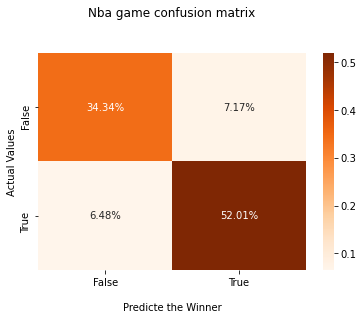

In [37]:
cm = metrics.confusion_matrix(Y_test,Y_pred)

print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Oranges')

ax.set_title('Nba game confusion matrix\n\n');
ax.set_xlabel('\nPredicte the Winner')
ax.set_ylabel('Actual Values');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

---

In [15]:
selected_distributions = [
    'norm','t', 'f', 'chi', 'cosine', 'alpha', 
    'beta', 'gamma', 'dgamma', 'dweibull',
    'maxwell', 'pareto', 'fisk', 'levy', 'moyal',
    'rayleigh']

In [16]:
unique_teams = df['HOME_TEAM_ID'].unique() # extract all the unique teams
print(unique_teams)

[1610612759 1610612747 1610612744 1610612739 1610612743 1610612740
 1610612763 1610612754 1610612753 1610612761 1610612751 1610612760
 1610612748 1610612762 1610612741 1610612737 1610612746 1610612750
 1610612756 1610612766 1610612738 1610612755 1610612764 1610612749
 1610612745 1610612742 1610612752 1610612765 1610612758 1610612757]


In [18]:
all_team_sim_data = {}

for team_name in unique_teams:
    
    # find games where the team is either the host or guest
    df_team = df.loc[(df['HOME_TEAM_ID'] == team_name) | (df['VISITOR_TEAM_ID'] == team_name)]
    # it is home team, select the first 5 features
    df_1 = df_team.loc[df_team['HOME_TEAM_ID'] == team_name][features]
    # it is guest team, select the first 5 features
    df_0 = df_team.loc[df_team['VISITOR_TEAM_ID'] == team_name][features]

    # combine them
    df_0.columns = df_1.columns # before concating, match the column names
    df_s = pd.concat([df_1, df_0], axis = 0)
    
    # convert the pandas.DataFrame to numpy array
    all_team_sim_data[team_name] = df_s.to_numpy()


In [38]:
all_team_sim_data 

{1610612759: array([[82.        , 82.        ,  0.707     , ...,  0.37286667,
         18.13333333, 38.        ],
        [82.        , 82.        ,  0.707     , ...,  0.35106667,
         20.33333333, 38.        ],
        [82.        , 82.        ,  0.707     , ...,  0.36186667,
         17.4       , 36.86666667],
        ...,
        [80.        , 79.        ,  0.563     , ...,  0.34573333,
         27.06666667, 46.33333333],
        [81.        , 81.        ,  0.63      , ...,  0.34926667,
         26.93333333, 46.53333333],
        [82.        , 82.        ,  0.439     , ...,  0.35913333,
         27.66666667, 45.26666667]]),
 1610612747: array([[82.        , 82.        ,  0.512     , ...,  0.3686    ,
         20.6       , 41.2       ],
        [82.        , 82.        ,  0.512     , ...,  0.35173333,
         22.66666667, 42.26666667],
        [82.        , 82.        ,  0.512     , ...,  0.3166    ,
         19.86666667, 42.13333333],
        ...,
        [78.        , 78.     

In [33]:
%%time

# data format:
#   team_name => list of feature distributions => distionary with distribution name and parameters
#   e.g.,
#   megadata = {
      #'Timberwolves': [{'beta': (0.23, 0.3, 0.3, 0.4)}, {'nor': (0.23, 0.3,)}, ..], 
      #'Warriors':[{}, {},...]
      #  }
    
megadata = {} # store the data that our Generator will rely on
for team_name in unique_teams:
    
    feature_dis_paras = []
    data = all_team_sim_data[team_name]
    
    # 5 features for each team
    for i in range(44): 
        f = Fitter(data[:, i]) # initalize a Fitter instance
        f.distributions = selected_distributions # use only the selected distributions (faster)
        f.fit() # do the fitting 
        best_paras = f.get_best(method='sumsquare_error') # get the best fitted paras
        feature_dis_paras.append(best_paras)
        
    megadata[team_name] = feature_dis_paras
    
print('Features for all teams have been fitted!')

Features for all teams have been fitted!
CPU times: user 40min 18s, sys: 15min, total: 55min 18s
Wall time: 36min 5s


In [21]:
print(megadata)

NameError: name 'megadata' is not defined

In [36]:
DATA = megadata.copy() # data that Generator must rely on

GEN = {
    'alpha': stats.alpha.rvs,
    'beta': stats.beta.rvs,
    'chi': stats.chi.rvs,
    'cosine': stats.cosine.rvs,
    'dgamma': stats.dgamma.rvs,
    'dweibull':stats.dweibull.rvs,
    'f':stats.f.rvs,
    'fisk':stats.fisk.rvs,
    'gamma': stats.gamma.rvs,
    'maxwell':stats.maxwell.rvs,
    'norm':stats.norm.rvs,
    'pareto':stats.pareto.rvs,
    't':stats.t.rvs,
    'levy': stats.levy.rvs,
    'moyal': stats.moyal.rvs,
    'rayleigh': stats.rayleigh.rvs
}

In [37]:
# feature scaler + fine-turned SVM 
DIS = make_pipeline(scaler, model)

In [46]:
class Game:
    
    '''
    
    A game between two teams:
    
    - feature values sampled from Generator
    - win/loss predicted by Discriminator
    
    '''
    
    def __init__ (self, random_state = None):
        
        self.random_state = random_state # keep this to None for making simulations 
    
    def predict(self, team1, team2):
        
        ''' predict the win or loss of  n game(s) played by two tems'''
        tf = pd.read_csv('../data/teams.csv')
        home_team_name = tf.loc[tf['TEAM_ID'] == int(team1)]['TEAM_NAME'].values
        away_team_name = tf.loc[tf['TEAM_ID'] == int(team2)]['TEAM_NAME'].values
        # output numpy array
        home_team_feature_data = DATA[team1]
        away_team_feature_data = DATA[team2]
        new_features = []
        for feature_paras_1 in home_team_feature_data:
            sample_1 = self.sampling(feature_paras_1, 1) # gives a list if num_games> 1
            new_features.append(sample_1) 
            
        for feature_paras_2 in away_team_feature_data:
            sample_2 = self.sampling(feature_paras_2, 1) # gives a list if num_games> 1
            new_features.append(sample_2)
            
        new_features = np.array(new_features).T
        win_loss = DIS.predict(new_features)
        
        if list(win_loss)[0] == 1:
            print(f"{home_team_name} win versus {away_team_name}")
        else:
            print(f"{away_team_name} win versus {home_team_name}")

        return list(win_loss) # a list of win/loss from num_games
    
    
    def sampling(self, dic, random_state = None):
        
        '''generate feature values used for making win/loss prediction'''
                        
        dis_name = list(dic.keys())[0] # get the type
        paras = list(dic.values())[0] # get the paras
#         dis_name = np.fromiter(dic.keys(), dtype=str)
#         paras = np.fromiter(dic.values(), dtype=float)
        
        # get sample
        sample = GEN[dis_name](**paras, random_state = random_state)
        return sample 

In [109]:
# [1610612759 1610612747 1610612744 1610612739 1610612743 1610612740
#  1610612763 1610612754 1610612753 1610612761 1610612751 1610612760
#  1610612748 1610612762 1610612741 1610612737 1610612746 1610612750
#  1610612756 1610612766 1610612738 1610612755 1610612764 1610612749
#  1610612745 1610612742 1610612752 1610612765 1610612758 1610612757]
for i in range(0,10):
    game = Game().predict(team1=1610612740, team2=1610612748)
    game

['Miami Heat'] win versus ['New Orleans Pelicans']
['Miami Heat'] win versus ['New Orleans Pelicans']
['Miami Heat'] win versus ['New Orleans Pelicans']
['Miami Heat'] win versus ['New Orleans Pelicans']
['New Orleans Pelicans'] win versus ['Miami Heat']
['Miami Heat'] win versus ['New Orleans Pelicans']
['Miami Heat'] win versus ['New Orleans Pelicans']
['Miami Heat'] win versus ['New Orleans Pelicans']
['Miami Heat'] win versus ['New Orleans Pelicans']
['Miami Heat'] win versus ['New Orleans Pelicans']
